# Handson ML 2 - Chapter 7 - Ensemble Classifier

This is simply a copy from [Hands-on Machine Learning with Scikit-Learn, Keras and TensorFlow 2nd edition - Chapter 7](https://github.com/ageron/handson-ml2/blob/master/07_ensemble_learning_and_random_forests.ipynb) to learn ensemble machine learning.

## Rational

* Law of large number  
Due to the central limit theory, if you have more independent samplings, the aggregated result approaches to the true value. Having 1000 people of 51% accuracy can achieve 75% accuracy collectively. 97% with 10,000.  (Integral of binomial(p=0.51) from 1 to 1000 -> 0.75).


* Effect of Randomness (Diversity)  
With diverse predictors either trained on random/independent samples or different algorithms, if there is a predictor who is biased to +, there is another predictor who is biased to -, hence cancelling out and yielding less bias and less variance result.

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "decision_trees"

def image_path(fig_id):
    return os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id)

def save_fig(fig_id, tight_layout=True):
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(image_path(fig_id) + ".png", format='png', dpi=300)

In [2]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

In [3]:
%%html
<!-- To left align the HTML components in Markdown -->
<style>
table {float:left}
</style>

In [4]:
%%bash
pwd

/home/oonisim/home/repositories/git/oonisim/Jupyter-Notebok


# Data

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Voting Classifier
Train multiple different algorithms (models) and orchestrate them.

Assemble a team of people with completely different capability, background, personality. Train each of them independently without any interactions. Make a decision based on the votes from them.

>Voting classifier often achieves a higher accuracy than the best classifier in the ensemble. Ensemble methods work best when the predictors are as independent from one another as possible. One way to get diverse classifiers is to train them using very different algorithms. This increases the chance that they will make very different types of errors, improving the ensemble’s accuracy.
>
><cite> Figure 7-2. Hard voting classifier predictions from Handson ML 2</cite>
> <img align="left" src="./images/ensemble_classifier/mls2_0702.png" width=500/>

## Hard voting
Hard voting takes up **the majority** (most frequent). Three voters say X, five voters say Y, two voters say Z, then the majority Y is the prediction.

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver="liblinear", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)
svm_clf = SVC(gamma="auto", random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')

In [7]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='warn',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=42,
                                                 solver='liblinear', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     class_weight=None,
                                                     criterion='gin...
                                        

### Performance  of Hard Voting

In [8]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.896


## Soft Voting
Soft voting takes up **the most confident** voter. If A says 97% confident, B says 91%, C says 98.9%, then C's prediction is the prediction.

In [9]:
log_clf = LogisticRegression(solver="liblinear", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)
svm_clf = SVC(gamma="auto", probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='warn',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=42,
                                                 solver='liblinear', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     class_weight=None,
                                                     criterion='gin...
                                        

### Performance of soft voting

In [10]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.912


# Bootstrap Aggregation (Bagging) Classifier
Train the same algorithm or model on randomely split data. 

Rather than one-fit-all specialist to adopt to the entire earth, split the earth into Africa, North America, South America, Asia, Oceania. Assign a clone of the same person with the same capability to each region to adopt. As a collective group, the clones can cope with the "planet earth" better than any sigle person.


> (Wikipedia) In statistics, bootstrapping is any test or metric that relies on random sampling with replacement.

> Use the same training algorithm for every predictor and train them on different random subsets of the training set. When sampling is performed with replacement, this method is called bagging1 (short for bootstrap aggregating2). When sampling is performed without replacement, it is called pasting. Bagging allows training instances to be sampled several times for the same predictor. 
>
><cite> Figure 7-4. Bagging and pasting involves training several predictors on different random samples of the training set from Handon ML 2 </cite>
><img align="left" src="./images/ensemble_classifier/mls2_0704.png" width=500/>  


> Each individual predictor has a higher bias than if |it were trained on the original training set, but aggregation reduces both bias and variance. Generally, the net result is that the ensemble has a similar bias but a lower variance than a single predictor trained on the original training set.

> The following code trains an ensemble of 500 Decision Tree classifiers:5 each is trained on 100 training instances randomly sampled from the training set with replacement (this is an example of bagging, but if you want to use pasting instead, just set bootstrap=False).

In [11]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

# The BaggingClassifier automatically performs soft voting instead of hard voting 
# if the base classifier can estimate class probabilities (i.e., if it has a predict_proba() method), 
# which is the case with Decision Tree classifiers.
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

0.856


In [12]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.904


Saving figure decision_tree_without_and_with_bagging_plot


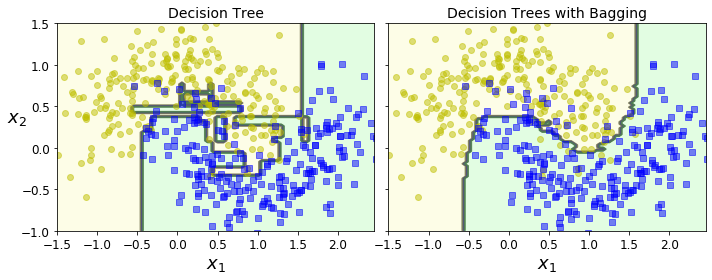

In [13]:
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")
save_fig("decision_tree_without_and_with_bagging_plot")
plt.show()

# Random Forest
> The Random Forest algorithm introduces extra randomness when growing trees; instead of searching for the very best feature when splitting a node, it searches for the best feature among a random subset of features. The algorithm results in greater tree diversity, which (again) trades a higher bias for a lower variance

In [14]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

In [15]:
from sklearn.metrics import accuracy_score
print(rnd_clf.__class__.__name__, accuracy_score(y_test, y_pred_rf))

RandomForestClassifier 0.92


## Extremely Randomized Tree
> Random thresholds for each feature rather than searching for the best possible thresholds. Trades more bias for a lower variance. It also makes Extra-Trees much faster to train than regular Random Forests, because finding the best possible threshold for each feature at every node is one of the most time-consuming tasks of growing a tree.

> It is hard to tell in advance whether a RandomForestClassifier will perform better or worse than an ExtraTreesClassifier. Generally, the only way to know is to try both and compare them using cross-validation (tuning the hyperparameters using grid search).

In [16]:
from sklearn.ensemble import ExtraTreesClassifier

ert_clf = ExtraTreesClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
ert_clf.fit(X_train, y_train)

y_pred_ert = ert_clf.predict(X_test)

In [17]:
from sklearn.metrics import accuracy_score
print(ert_clf.__class__.__name__, accuracy_score(y_test, y_pred_ert))

ExtraTreesClassifier 0.92


## Feature Importance
> Random Forests is that they make it easy to measure the relative importance of each feature. Scikit-Learn measures a feature’s importance by looking at how much the tree nodes that use that feature reduce impurity on average (across all trees in the forest). More precisely, it is a weighted average, where each node’s weight is equal to the number of training samples that are associated. You can access the result using the feature_importances_ variable.

In [18]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


# Boosting

Boosting works on the errors of the pervious perdictor, hence a sequential training.

> Boosting (originally called hypothesis boosting) refers to any Ensemble method that can combine several weak learners into a strong learner. The general idea of most boosting methods is to train predictors sequentially, each trying to correct its predecessor. 

## Adaptive Boosting

The successor works on those data points which the predecessor miss-identified, by increasing weights on them.

> the algorithm first trains a base classifier (such as a Decision Tree) and uses it to make predictions on the training set. The algorithm then increases the relative weight of misclassified training instances. Then it trains a second classifier, using the updated weights, and again makes predictions on the training set, updates the instance weights, and so on
><img align="left" src="./images/ensemble_classifier/mls2_0707.png" width=500/>  

## Demonstration of adaptive model training using SVM with RBF
For those training data that did not get predicted correctly ("y_pred != y_train"), the weights get increased.

Saving figure boosting_plot


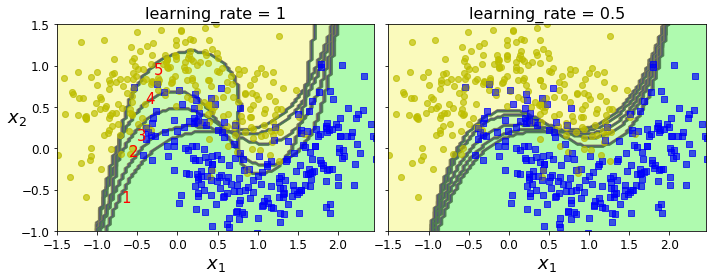

In [19]:
m = len(X_train)

fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
for subplot, learning_rate in ((0, 1), (1, 0.5)):
    sample_weights = np.ones(m)
    plt.sca(axes[subplot])
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.05, gamma="scale", random_state=42)
        
        # --------------------------------------------------------------------------------
        # Train with more emphasis based on sample weights
        # --------------------------------------------------------------------------------
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights)
        
        # --------------------------------------------------------------------------------
        # Increase weights by (1 + learning_rate) on those X_train data that did not get 
        # predicted correctly ("y_pred != y_train"). Then the next training will put more
        # emphais on those.
        # --------------------------------------------------------------------------------
        y_pred = svm_clf.predict(X_train)
        sample_weights[y_pred != y_train] *= (1 + learning_rate)
        
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
    if subplot == 0:
        plt.text(-0.7, -0.65, "1", fontsize=14, color="r", size=15)
        plt.text(-0.6, -0.10, "2", fontsize=14, color="r", size=15)
        plt.text(-0.5,  0.10, "3", fontsize=14, color="r", size=15)
        plt.text(-0.4,  0.55, "4", fontsize=14, color="r", size=15)
        plt.text(-0.3,  0.90, "5", fontsize=14, color="r", size=15)
    else:
        plt.ylabel("")

save_fig("boosting_plot")
plt.show()

In [20]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    SVC(kernel="rbf", C=0.05, gamma="scale", random_state=42, probability=True), 
    n_estimators=200,
    algorithm="SAMME.R", 
    learning_rate=1.0, 
    random_state=42
)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=SVC(C=0.05, cache_size=200, class_weight=None,
                                      coef0=0.0, decision_function_shape='ovr',
                                      degree=3, gamma='scale', kernel='rbf',
                                      max_iter=-1, probability=True,
                                      random_state=42, shrinking=True,
                                      tol=0.001, verbose=False),
                   learning_rate=1.0, n_estimators=200, random_state=42)

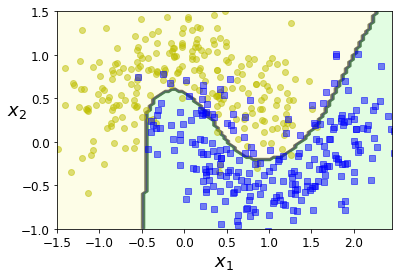

In [21]:
plot_decision_boundary(ada_clf, X, y)

In [22]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf_100 = AdaBoostClassifier(
    SVC(kernel="rbf", C=0.05, gamma="scale", random_state=42, probability=True), 
    n_estimators=100,
    algorithm="SAMME.R", 
    learning_rate=1.0, 
    random_state=42
)
ada_clf_100.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=SVC(C=0.05, cache_size=200, class_weight=None,
                                      coef0=0.0, decision_function_shape='ovr',
                                      degree=3, gamma='scale', kernel='rbf',
                                      max_iter=-1, probability=True,
                                      random_state=42, shrinking=True,
                                      tol=0.001, verbose=False),
                   learning_rate=1.0, n_estimators=100, random_state=42)

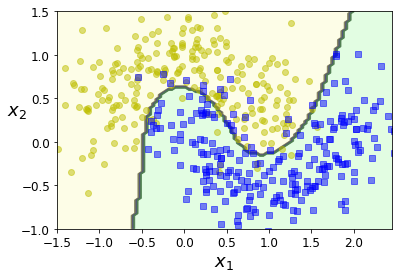

In [23]:
plot_decision_boundary(ada_clf_100, X, y)

## Gradient Boosting
The successor works on those data points which the predecessor miss-identified, by taking distances/differentials between expected and actual predictions. Similar approach to approximation/interpolation such as Fourier where the linear sum of functions approximates the target.


> Instead of tweaking the instance weights at every iteration like AdaBoost does, this method tries to fit the new predictor to the residual errors made by the previous predictor.

In [24]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [25]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [26]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [27]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

In [28]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=1.0, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=3,
                          n_iter_no_change=None, presort='auto',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [29]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=200,
                          n_iter_no_change=None, presort='auto',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

Saving figure gbrt_learning_rate_plot


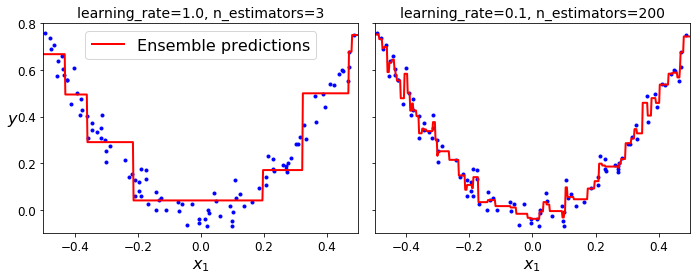

In [30]:
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)

save_fig("gbrt_learning_rate_plot")
plt.show()

## XGBoost

In [31]:
try:
    import xgboost
except ImportError as ex:
    print("Error: the xgboost library is not installed.")
    xgboost = None

# Stacking
Neural neteork like approach to have a predictor trained on the outputs of the predictors. 